# Import Necessary Libs

In [1]:
seed = 999

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random

In [3]:
np.random.seed(seed)
random.seed(seed)

## Load Dataset

In [4]:
import os
os.chdir('C:/Users/Mashal/Documents/Projects/MAL Recommender System')

# Split Dataset into Training Dataset and Testing Dataset

In [4]:
full_df = pd.read_csv('../animelists_cleaned.csv')
full_df

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN
...,...,...,...,...,...,...,...,...,...,...,...
31284025,Yokonightcore,15611,48,2014-00-00,0000-00-00,9,1,NaN,0,2015-09-07 17:33:03,NaN
31284026,Yokonightcore,27815,22,0000-00-00,0000-00-00,9,1,NaN,0,2015-09-07 17:32:05,NaN
31284027,wargod,5945,39,0000-00-00,0000-00-00,8,2,0.0,0,2010-03-29 04:24:12,NaN
31284028,JMc_SetoKai_LoVe,1316,52,0000-00-00,0000-00-00,9,2,NaN,0,2009-12-23 05:45:14,NaN


Drop rows where username is missing

In [5]:
full_df = full_df.dropna(subset=['username'])

Drop rows where show score is zero, as this means it is unrated, and therefore useless data

In [6]:
full_df = full_df[full_df['my_score'] > 0]

In [7]:
full_df.describe()

,anime_id,my_watched_episodes,my_score,my_status,my_rewatching,my_rewatching_ep
count,1.917195e+07,1.917195e+07,1.917195e+07,1.917195e+07,1.411264e+07,1.917195e+07
mean,1.127331e+04,1.809466e+01,7.591404e+00,2.081085e+00,1.202398e-03,2.989212e-01
std,1.101460e+04,4.303521e+01,1.706195e+00,5.134124e-01,3.465475e-02,1.289120e+03
min,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.562000e+03,2.000000e+00,7.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,7.724000e+03,1.200000e+01,8.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
75%,1.867700e+04,2.200000e+01,9.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
max,3.786000e+04,9.999000e+03,1.000000e+01,3.300000e+01,1.000000e+00,5.644513e+06


## Exploratory data analysis

In [9]:
sns.set(rc = {'figure.figsize':(10,10)})

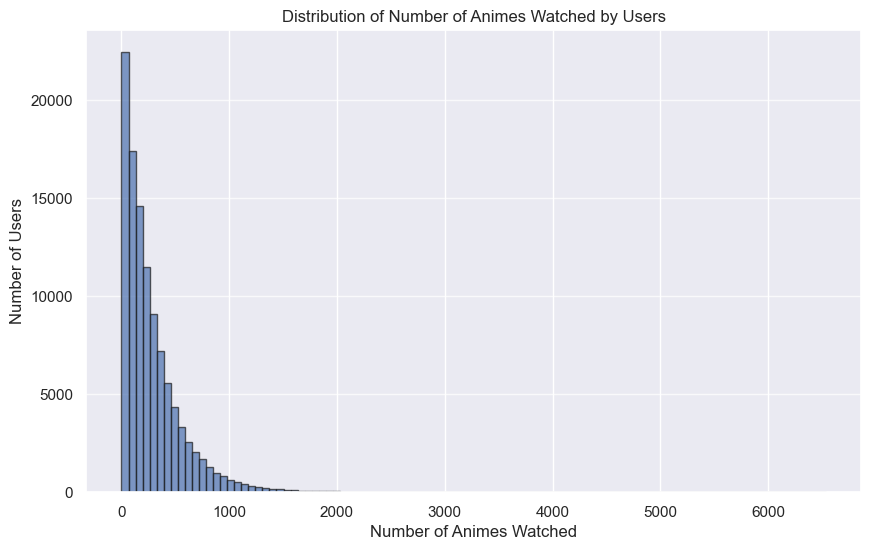

In [16]:
# Step 1: Count the number of animes each user has watched
user_anime_counts = full_df['username'].value_counts()

# Step 2: Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(user_anime_counts, bins=100, edgecolor='k', alpha=0.7)
plt.title('Distribution of Number of Animes Watched by Users')
plt.xlabel('Number of Animes Watched')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [7]:
full_df['username'].value_counts()

_thiagobrisolla    3785
misterferrari      3442
Shouichirou        3439
SakataYusuke       3383
Kannei             3285
                   ... 
psithurism            1
shaz40                1
karkat                1
Miikan-chan           1
hinogurl_mikha        1
Name: username, Length: 106401, dtype: int64

C:\Users\Mashal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


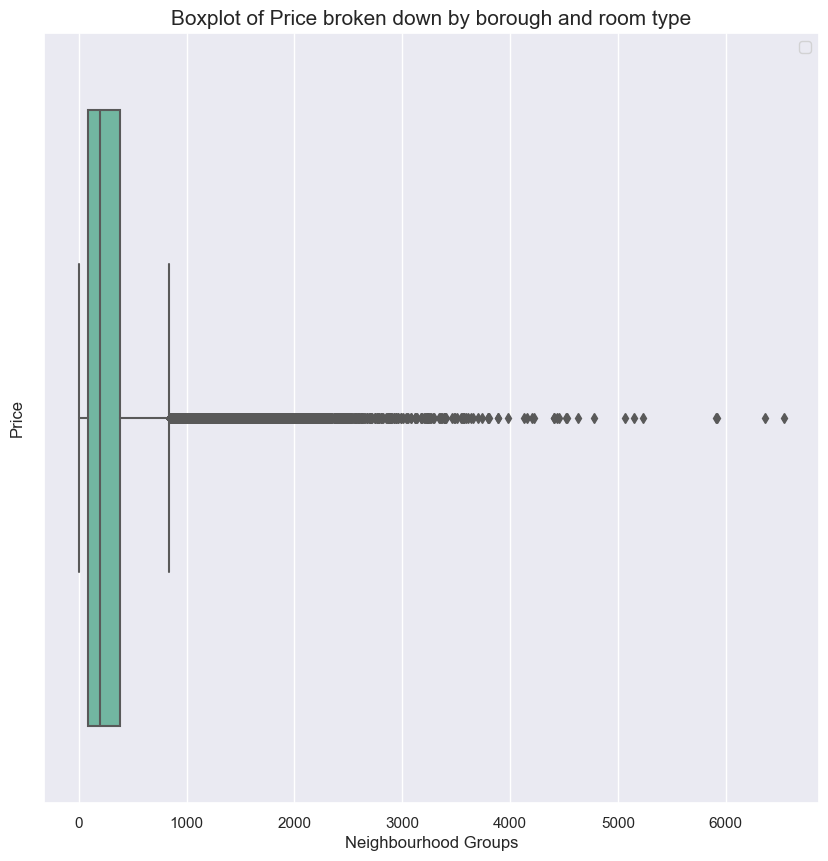

In [18]:
sns.boxplot(user_anime_counts, palette="Set2")
plt.title('Boxplot of Price broken down by borough and room type', fontsize = 15)
plt.xlabel('Neighbourhood Groups')
plt.ylabel('Price')
plt.legend(bbox_to_anchor=(1, 1))
plt.show();

In [27]:
full_df[full_df['username'] != "karthiga"]

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
53,Damonashu,21,418,0000-00-00,0000-00-00,10,1,0.0,0,2009-09-30 07:39:05,NaN
55,Damonashu,249,167,0000-00-00,0000-00-00,4,2,0.0,0,1970-01-01 00:00:00,NaN
56,Damonashu,269,0,0000-00-00,0000-00-00,2,4,NaN,0,1970-01-01 00:00:00,NaN
57,Damonashu,853,26,0000-00-00,2009-07-31,6,2,0.0,0,2009-07-31 21:07:47,NaN
58,Damonashu,857,25,0000-00-00,2008-08-11,4,2,0.0,0,2008-08-11 17:45:54,NaN
...,...,...,...,...,...,...,...,...,...,...,...
31284025,Yokonightcore,15611,48,2014-00-00,0000-00-00,9,1,NaN,0,2015-09-07 17:33:03,NaN
31284026,Yokonightcore,27815,22,0000-00-00,0000-00-00,9,1,NaN,0,2015-09-07 17:32:05,NaN
31284027,wargod,5945,39,0000-00-00,0000-00-00,8,2,0.0,0,2010-03-29 04:24:12,NaN
31284028,JMc_SetoKai_LoVe,1316,52,0000-00-00,0000-00-00,9,2,NaN,0,2009-12-23 05:45:14,NaN


Keep removing users at random until a user threshold is reached

In [ ]:
# usernames = full_df['username'].unique()
# np.random.shuffle(usernames)
# limit = 10000
# username_ind = 0
# while len(full_df['username'].unique()) > limit:
#     full_df = full_df[full_df['username'] != usernames[username_ind]]
#     username_ind += 1

In [8]:
# Get unique users
unique_users = full_df['username'].unique()

# Randomly select users to keep (10,000)
num_users_to_keep = min(len(unique_users), 1000)  # Ensure we keep at most 10,000 users
selected_users = np.random.choice(unique_users, size=num_users_to_keep, replace=False)

# Filter the DataFrame to retain only rows with the selected users
anime_df = full_df[full_df['username'].isin(selected_users)]

print(f"Original number of unique users: {len(unique_users)}")
print(f"Number of unique users after filtering: {anime_df['username'].nunique()}")
print(anime_df.head())

Original number of unique users: 106401
Number of unique users after filtering: 1000
        username  anime_id  my_watched_episodes my_start_date my_finish_date  \
9564  magedgamed        21                  688    0000-00-00     0000-00-00   
9565  magedgamed        59                   26    0000-00-00     2016-08-12   
9566  magedgamed       120                   26    2015-12-12     2015-12-13   
9567  magedgamed       232                   70    0000-00-00     2016-03-21   
9569  magedgamed       249                  167    0000-00-00     2017-02-05   

      my_score  my_status  my_rewatching  my_rewatching_ep  \
9564         9          3            NaN                 0   
9565         6          2            0.0                 0   
9566         7          2            0.0                 0   
9567         7          2            0.0                 0   
9569         6          2            0.0                 0   

          my_last_updated       my_tags  
9564  2015-06-01 18

In [9]:
unique_ids = anime_df['anime_id'].unique()
# Gets list of unique IDs and sorts them
unique_ids = np.sort(unique_ids)
# Contains translations from anime IDs to numpy array indices
idToInd = {}
# Initialises array to size of unique IDs, but will change contents to ascending order
indToId = np.array(unique_ids)
for i in range(len(unique_ids)):
    idToInd[unique_ids[i]] = i
    indToId[i] = unique_ids[i]

Adds user ID column

In [10]:
anime_df['user_id'] = pd.factorize(anime_df['username'])[0]

C:\Users\Mashal\AppData\Local\Temp\ipykernel_67384\278079498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_df['user_id'] = pd.factorize(anime_df['username'])[0]


In [11]:
train_df, test_df = train_test_split(anime_df, test_size=0.2)
train_df, test_df

(                username  anime_id  my_watched_episodes my_start_date  \
 9009253        RaizenSun     27775                   13    0000-00-00   
 24290223        elmis003     15583                   12    0000-00-00   
 14269793           Yuu25      6922                    1    0000-00-00   
 5960409      Mushinkeina     11013                   12    2012-05-16   
 1778471             June       523                    1    0000-00-00   
 ...                  ...       ...                  ...           ...   
 19102706  DeathwolfBigbo       379                   26    0000-00-00   
 6213077   shadow_wolf_92     32188                    1    0000-00-00   
 3604417        PsyQonaut     23605                   26    2018-04-01   
 14825991       xxxfoxxxx     19951                    1    2015-08-29   
 26554521   Halloween8182      2236                    1    0000-00-00   
 
          my_finish_date  my_score  my_status  my_rewatching  my_rewatching_ep  \
 9009253      2015-07-01    

In [11]:
for row in train_df.itertuples():
    print(row)
    break

Pandas(Index=27830841, username='Shortredguy', anime_id=5682, my_watched_episodes=0, my_start_date='0000-00-00', my_finish_date='0000-00-00', my_score=0, my_status=6, my_rewatching=0.0, my_rewatching_ep=0, my_last_updated='2010-12-21 01:19:25', my_tags=nan, user_id=6361)


In [12]:
print(train_df.itertuples(index=False).__next__()._fields)


('username', 'anime_id', 'my_watched_episodes', 'my_start_date', 'my_finish_date', 'my_score', 'my_status', 'my_rewatching', 'my_rewatching_ep', 'my_last_updated', 'my_tags', 'user_id')


In [13]:
anime_df[(anime_df['user_id']==40352)] #  & (anime_df['anime_id']==indToId[3])

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags,user_id


In [12]:
n_users = anime_df['user_id'].nunique()
n_items = anime_df['anime_id'].nunique()

In [13]:
train_df.sort_values(by='user_id')

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags,user_id
9990,magedgamed,34280,12,0000-00-00,2017-10-30,7,2,0.0,0,2017-10-29 22:05:07,"HEADER, lone",0
9929,magedgamed,24833,22,0000-00-00,2015-09-17,9,2,0.0,0,2015-09-17 15:36:39,"HEADER,",0
9800,magedgamed,10793,22,0000-00-00,0000-00-00,8,2,0.0,0,2016-04-24 16:50:10,"HEADER, lone",0
9877,magedgamed,17247,12,0000-00-00,0000-00-00,6,2,0.0,0,2015-03-21 22:54:40,"HEADER, lone",0
10509,magedgamed,455,26,0000-00-00,0000-00-00,8,2,0.0,0,2017-02-11 14:16:17,"HEADER, lone",0
...,...,...,...,...,...,...,...,...,...,...,...,...
31281858,bunnyboo5345,1642,51,0000-00-00,0000-00-00,10,2,0.0,0,2014-04-15 04:22:45,NaN,997
31281853,bunnyboo5345,7645,49,0000-00-00,0000-00-00,10,2,0.0,0,2014-04-15 04:10:18,NaN,997
31283506,murasakigirl7,532,38,2008-12-07,2008-12-07,10,2,0.0,0,2008-12-07 20:36:47,NaN,998
31283910,Animeangel54,7334,39,2012-01-06,2012-01-11,9,2,0.0,0,2012-06-09 14:28:39,NaN,999


In [14]:
# Training dataset
train_ds = np.zeros((n_users, n_items))
for row in train_df.itertuples():
    train_ds[row.user_id, idToInd[row.anime_id]] = row.my_score
train_ds = pd.DataFrame(train_ds)

# Testing dataset
test_ds = np.zeros((n_users, n_items))
for row in test_df.itertuples():
    test_ds[row.user_id, idToInd[row.anime_id]] = row.my_score
test_ds = pd.DataFrame(test_ds)

train_ds, test_ds

(     0     1     2     3     4     5     6     7     8     9     ...  5437  \
 0     8.0   0.0   7.0   0.0   0.0   0.0   8.0   0.0   0.0   9.0  ...   0.0   
 1     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 2     9.0   0.0   0.0   0.0   0.0   8.0   0.0   0.0   0.0   0.0  ...   0.0   
 3     7.0   6.0   7.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 4     9.0   0.0   0.0   0.0   0.0   9.0   0.0   0.0   8.0   9.0  ...   0.0   
 ..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
 995   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 996   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 997   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 998   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 999   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 
      5438  5439  5440  5441  5442  5443  5444  54

# Fitting the Algorithm

## User-based

### Compute Pearson Correlation Coefficient for Each Pair of Users in Training Dataset

In [15]:
GAMMA = 30
EPSILON = 1e-9

np_user_pearson_corr = np.zeros((n_users, n_users))

for i, user_i_vec in enumerate(train_ds.values):
    for j, user_j_vec in enumerate(train_ds.values):

        # ratings corated by the current pair od users
        mask_i = user_i_vec > 0
        mask_j = user_j_vec > 0

        # corrated item index, skip if there are no corrated ratings
        corrated_index = np.intersect1d(np.where(mask_i), np.where(mask_j))
        if len(corrated_index) == 0:
            continue

        # average value of user_i_vec and user_j_vec
        mean_user_i = np.sum(user_i_vec) / (np.sum(np.clip(user_i_vec, 0, 1)) + EPSILON)
        mean_user_j = np.sum(user_j_vec) / (np.sum(np.clip(user_j_vec, 0, 1)) + EPSILON)

        # compute pearson corr
        user_i_sub_mean = user_i_vec[corrated_index] - mean_user_i
        user_j_sub_mean = user_j_vec[corrated_index] - mean_user_j

        r_ui_sub_r_i_sq = np.square(user_i_sub_mean)
        r_uj_sub_r_j_sq = np.square(user_j_sub_mean)

        r_ui_sum_sqrt = np.sqrt(np.sum(r_ui_sub_r_i_sq))
        r_uj_sum_sqrt = np.sqrt(np.sum(r_uj_sub_r_j_sq))

        sim = np.sum(user_i_sub_mean * user_j_sub_mean) / (r_ui_sum_sqrt * r_uj_sum_sqrt + EPSILON)

        # significance weighting
        weighted_sim = (min(len(corrated_index), GAMMA) / GAMMA) * sim

        np_user_pearson_corr[i][j] = weighted_sim

np_user_pearson_corr

array([[ 1.00000000e+00,  5.03061363e-01,  2.24522400e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.03061363e-01,  1.00000000e+00, -1.32513908e-03, ...,
         3.33333333e-02,  0.00000000e+00,  0.00000000e+00],
       [ 2.24522400e-01, -1.32513908e-03,  1.00000000e+00, ...,
        -3.43213766e-02,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  3.33333333e-02, -3.43213766e-02, ...,
         7.00000000e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  3.33333355e-09,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  6.66666665e-02]])

### Predict Ratings

In [16]:
np_predictions = np.zeros((n_users, n_items))

K = 100
EPSILON = 1e-9

for (i, j), rating in np.ndenumerate(test_ds.values):
    if rating > 0:
        # find top-k most similar users as the current user, remove itself
        sim_user_ids = np.argsort(np_user_pearson_corr[i])[-(K + 1):-1]

        # the coefficient values of similar users
        sim_val = np_user_pearson_corr[i][sim_user_ids]

        # the average value of the current user's ratings
        sim_users = train_ds.values[sim_user_ids]
        user_mean = np.sum(train_ds.values[i]) / (np.sum(np.clip(train_ds.values[i], 0, 1)) + EPSILON)
        sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)

        # select the users who rated item j
        mask_rated_j = sim_users[:, j] > 0
        
        # sim(u, v) * (r_vj - mean_v)
        sim_r_sum_mean = sim_val[mask_rated_j] * (sim_users[mask_rated_j, j] - sim_user_mean[mask_rated_j])

        # filter unrated items
        #w = np.clip(sim_users[mask_rated_j, j], 0, 1)
        #sim_r_sum_mean *= w
        #print(sim_users[:, j])
        
        np_predictions[i][j] = user_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val[mask_rated_j]) + EPSILON)
        np_predictions[i][j] = np.clip(np_predictions[i][j], 0, 5)
    

### Evaluation

#### Mean Absolute Error (MAE)

In [18]:
#==================MAE on Testing set===================#
labels = test_ds.values

# absolute error on all ratings
absolute_error = np.abs(np_predictions - labels)

# weight
weight = np.clip(labels, 0, 1)

# absoulte error on rated ratings
abs_error = absolute_error * weight

# MAE
MAE = np.sum(abs_error) / np.sum(weight)

print("MAE on Tesing set (User-based): " + str(MAE));

MAE on Tesing set (User-based): 2.787752858583107


#### Root Mean Squared Error (RMSE)

In [17]:
#==================RMSE on Testing set===================
labels = test_ds.values

# squared error on all ratings
squared_error = np.square(np_predictions - labels)
weight = np.clip(labels, 0, 1)

# squared error on rated ratings
squared_error = squared_error * weight

# RMSE
RMSE = np.sqrt(np.sum(squared_error) / np.sum(weight))

print("RMSE on Tesing set (User-based): " + str(RMSE));

RMSE on Tesing set (User-based): 3.118499482881684


## Item-based

### Compute Pearson Correlation Coefficient for Each Pair of Users in Training Dataset

In [ ]:
DELTA = 25
EPSILON = 1e-9

np_item_pearson_corr = np.zeros((n_items, n_items))

for i, item_i_vec in enumerate(train_ds.T.values):
    for j, item_j_vec in enumerate(train_ds.T.values):

        # ratings corated by the current pair od items
        mask_i = item_i_vec > 0
        mask_j = item_j_vec > 0

        # corrated index, skip if there are no corrated ratings
        corrated_index = np.intersect1d(np.where(mask_i), np.where(mask_j))
        if len(corrated_index) == 0:
            continue

        # average value of item_i_vec and item_j_vec
        mean_item_i = np.sum(item_i_vec) / (np.sum(np.clip(item_i_vec, 0, 1)) + EPSILON)
        mean_item_j = np.sum(item_j_vec) / (np.sum(np.clip(item_j_vec, 0, 1)) + EPSILON)

        # compute pearson corr
        item_i_sub_mean = item_i_vec[corrated_index] - mean_item_i
        item_j_sub_mean = item_j_vec[corrated_index] - mean_item_j

        r_ui_sub_ri_sq = np.square(item_i_sub_mean)
        r_uj_sub_rj_sq = np.square(item_j_sub_mean)

        r_ui_sub_ri_sq_sum_sqrt = np.sqrt(np.sum(r_ui_sub_ri_sq))
        r_uj_sub_rj_sq_sum_sqrt = np.sqrt(np.sum(r_uj_sub_rj_sq))

        sim = np.sum(item_i_sub_mean * item_j_sub_mean) / (r_ui_sub_ri_sq_sum_sqrt * r_uj_sub_rj_sq_sum_sqrt + EPSILON)

        # significance weighting
        weighted_sim = (min(len(corrated_index), DELTA) / DELTA) * sim

        np_item_pearson_corr[i][j] = weighted_sim

np_item_pearson_corr

### Predict Ratings

In [ ]:
np_predictions = np.zeros((n_users, n_items))

K = 10
EPSILON = 1e-9

for (i, j), rating in np.ndenumerate(test_ds.values):
    if rating > 0:
        # find top-k most similar items as the current item, remove itself
        sim_item_ids = np.argsort(np_item_pearson_corr[j])[-(K + 1):-1]

        # the coefficient values of similar items
        sim_val = np_item_pearson_corr[j][sim_item_ids]

        # the average value of the current item's ratings
        sim_items = train_ds.T.values[sim_item_ids]
        item_mean = np.sum(train_ds.T.values[j]) / (np.sum(np.clip(train_ds.T.values[j], 0, 1)) + EPSILON)
        sim_item_mean = np.sum(sim_items, axis=1) / (np.sum(np.clip(sim_items, 0, 1), axis=1) + EPSILON)

        # sim(u, v) * (r_v - mean_v)
        sim_r_sum_mean = sim_val * (sim_items[:, i] - sim_item_mean) 

        # filter unrated items
        w = np.clip(sim_items[:, i], 0, 1)
        sim_r_sum_mean *= w

        np_predictions[i][j] = item_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val * w) + EPSILON)    
        np_predictions[i][j] = np.clip(np_predictions[i][j], 0, 5)
    

### Evaluation

#### Mean Absolute Error (MAE)

In [ ]:
#==================MAE on Testing set===================#
labels = test_ds.values

# absolute error on all ratings
absolute_error = np.abs(np_predictions - labels)

# weight
weight = np.clip(labels, 0, 1)

# absoulte error on rated ratings
abs_error = absolute_error * weight

# MAE
MAE = np.sum(abs_error) / np.sum(weight)

print("MAE on Tesing set (Item-based): " + str(MAE));

#### Root Mean Squared Error (RMSE)

In [ ]:
#==================RMSE on Testing set===================#
labels = test_ds.values

# squared error on all ratings
squared_error = np.square(np_predictions - labels)
weight = np.clip(labels, 0, 1)

# squared error on rated ratings
squared_error = squared_error * weight

# RMSE
RMSE = np.sqrt(np.sum(squared_error) / np.sum(weight))

print("RMSE on Tesing set (Item-based): " + str(RMSE));